In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_path = "../data/processed/processed.csv"
df = pd.read_csv(data_path)
print("✅ Data loaded successfully!")


✅ Data loaded successfully!


In [3]:
target_col = "AQI"
X = df.drop(columns=[target_col])
y = df[target_col]


In [5]:
# 📌 Step: Handle NaNs and Ensure Numeric Columns

# Prepare features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert all non-numeric columns to NaN and ensure numeric values
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Ensure NaN values are filled with the column mean for X_train and X_test
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Ensure y_train is also filled with its mean (in case it has NaN values)
y_train = y_train.fillna(y_train.mean())

# Check if there are still any NaNs in X_train or X_test
print(f"Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"Missing values in X_test: {X_test.isna().sum().sum()}")
print(f"Missing values in y_train: {y_train.isna().sum()}")


Missing values in X_train: 70872
Missing values in X_test: 17721
Missing values in y_train: 0


In [6]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(f"Cross-validation scores: {cv_scores}")
print(f"Average MSE across folds: {-cv_scores.mean()}")


Cross-validation scores: [-1540.45121125 -2730.07124068 -2210.54719668 -2669.23697639
 -2115.81229911]
Average MSE across folds: 2253.2237848222258


In [7]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [8]:
# 📌 Step 8: Evaluate Tuned Random Forest Model
best_rf_model = grid_search.best_estimator_
y_rf_pred = best_rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_mae = mean_absolute_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

# Print metrics
print(f"Random Forest Model - MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")

# 📌 Step 11: Save Trained Random Forest Model to the models folder
joblib.dump(best_rf_model, "../models/random_forest_model.pkl")
print("✅ Random Forest model saved to file!")


Random Forest Model - MSE: 1765.2540, MAE: 20.4283, R²: 0.8829
✅ Random Forest model saved to file!


In [12]:
# After training, before saving the model
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "../models/feature_columns.pkl")
print("✅ Feature columns saved!")


✅ Feature columns saved!


In [19]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd

# Load model and feature columns
nn_model = load_model("../models/neural_network_model.keras")
feature_columns = joblib.load("../models/feature_columns.pkl")  # list of columns used in training

# Load processed data
df = pd.read_csv("../data/processed/processed.csv")
X = df.drop(columns=["AQI"])
y = df["AQI"]

# Align test data with training features
X = X[feature_columns]

# Split and preprocess
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values only in numeric columns
X_test[X_test.select_dtypes(include='number').columns] = X_test.select_dtypes(include='number').fillna(
    X_test.select_dtypes(include='number').mean()
)

# Reset indices
X_test.reset_index(drop=True, inplace=True)
y_test = y_test.reset_index(drop=True)

from tensorflow.keras.models import load_model

# Load model
nn_model_path = "../models/neural_network_model.keras"
nn_model = load_model(nn_model_path)
print("✅ Neural Network model loaded!")

# Drop non-numeric columns
X_test = X_test.select_dtypes(include='number')

# Predict
nn_predictions = nn_model.predict(X_test)
nn_predictions = nn_predictions.ravel()


✅ Neural Network model loaded!
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [20]:
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

print(f"NN Model - MSE: {nn_mse:.4f}, MAE: {nn_mae:.4f}, R²: {nn_r2:.4f}")


NN Model - MSE: 35781635.0004, MAE: 5196.3137, R²: -2372.4892


✅ Random Forest model loaded from file!
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


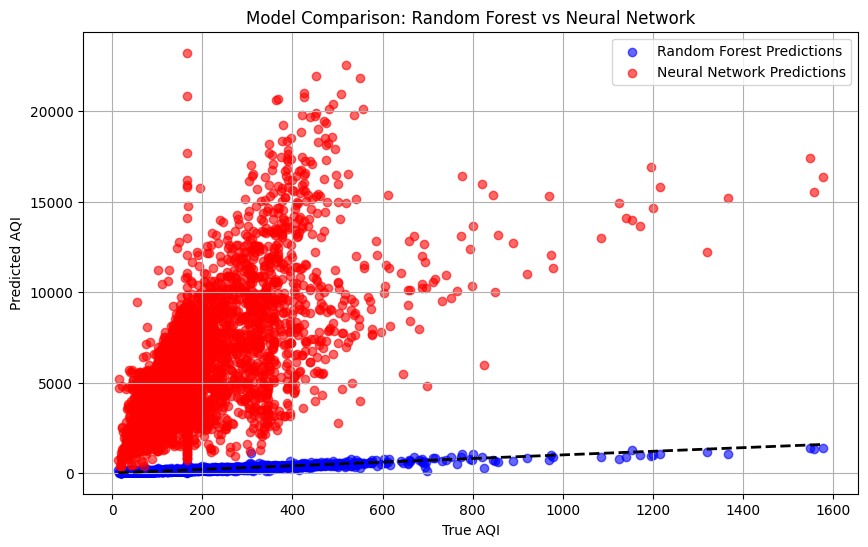

In [31]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Load Random Forest model
try:
    rf_model_loaded = joblib.load("../models/random_forest_model.pkl")
    print("✅ Random Forest model loaded from file!")
except:
    rf_model_loaded = best_rf_model
    print("✅ Random Forest model used from training (no saved model found).")

# ✅ Load feature columns used during training
feature_columns = joblib.load('../models/feature_columns.pkl')

# ✅ Ensure X_test is clean and matches training features
X_test = X_test.copy()
X_test = X_test.select_dtypes(include='number')
X_test.fillna(X_test.mean(), inplace=True)

# ✅ Filter X_test to include only available feature columns
feature_columns = [col for col in feature_columns if col in X_test.columns]
X_test = X_test[feature_columns]

# ✅ Make predictions

nn_predictions = nn_model.predict(X_test).ravel()

# ✅ Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_rf_pred, color='blue', label='Random Forest Predictions', alpha=0.6)
plt.scatter(y_test, nn_predictions, color='red', label='Neural Network Predictions', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True AQI')
plt.ylabel('Predicted AQI')
plt.legend()
plt.title('Model Comparison: Random Forest vs Neural Network')
plt.grid(True)
plt.show()
